# **Prophet**

In [35]:
import itertools, warnings, os, subprocess
from pathlib import Path
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go

In [37]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

def download_data(dataset, path):
    # Create local folder if one doesn't exist
    os.makedirs(path, exist_ok=True)
    # Call Kaggle API
    kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

# Download additional datasets from Konrad's NB
dataset = "niclowe/who-cases-dataset-and-wdi-country-population"
download_path = "data/who-data"

download_data(dataset, download_path)

Dataset URL: https://www.kaggle.com/datasets/niclowe/who-cases-dataset-and-wdi-country-population
License(s): unknown


  0%|                                               | 0.00/107k [00:00<?, ?B/s]


Dataset 'niclowe/who-cases-dataset-and-wdi-country-population' has been downloaded to 'data/who-data'


100%|████████████████████████████████████████| 107k/107k [00:00<00:00, 175kB/s]


In [61]:
data = 'data/'

class CFG:
    img_dim1 = 12
    img_dim2 = 10

# Set Param for visualizations
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

## A Primer on Generalized Additive Models (GAM)

In previous NBs, we covered exponential smoothing which is pretty useful as a first-pass modelling approach but is seriously hampered since it only handles one seasonal pattern at a time. This led to the development of Prophet at Facebook, which is based on the concept of structural decomposition.

$$
X_t = T_t + S_t + H_t + \epsilon_t
$$

where:
- $T_t$        is the observed time series at time.
- $S_t$        is the seasonal component (which can be weekly, yearly or custom)
- $H_T$        is the deterministic irregular component (holidays, discontinuities etc.)
- $\epsilon_t$ is the noise

The Kolmogorov-Arnold representation theorem states that multivariate functions could be represented as sums and compositions of univariate functions. The simplified general representation is as follows:

$$ \Phi^{-1}[\mathbb{E}(Y)] = \beta_0 + f_1(x_1) + f_2(x_2) + \cdots + f_m(x_m) $$

The GAM decomposition is used as the starting point for Prophet. We will now look at the implementations of two trend models next.

## Trend Model

### Linear Trend

The default trend model is a:

> Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

> By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.

In [62]:
# Using the New York Times data on Covid cases for demo purposes
df = pd.read_csv(data + 'us_covid.csv')
df.head(10)

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
5,2020-01-26,5,0
6,2020-01-27,5,0
7,2020-01-28,5,0
8,2020-01-29,5,0
9,2020-01-30,6,0


In [63]:
df.describe().round(2)

,cases,deaths
count,594.00,594.00
mean,16034557.83,308550.07
std,13906317.76,224858.33
min,1.00,0.00
25%,2184128.75,117927.75
50%,10728694.00,243560.00
75%,31147891.50,561082.00
max,40005266.00,648273.00


The most _annoying_ feature in Prophet - by far - is the usage of a hardcoded format for inputs. This **must** be a date column named `ds` which can either be an index or column. A column `y` stores the actual values of the time series.

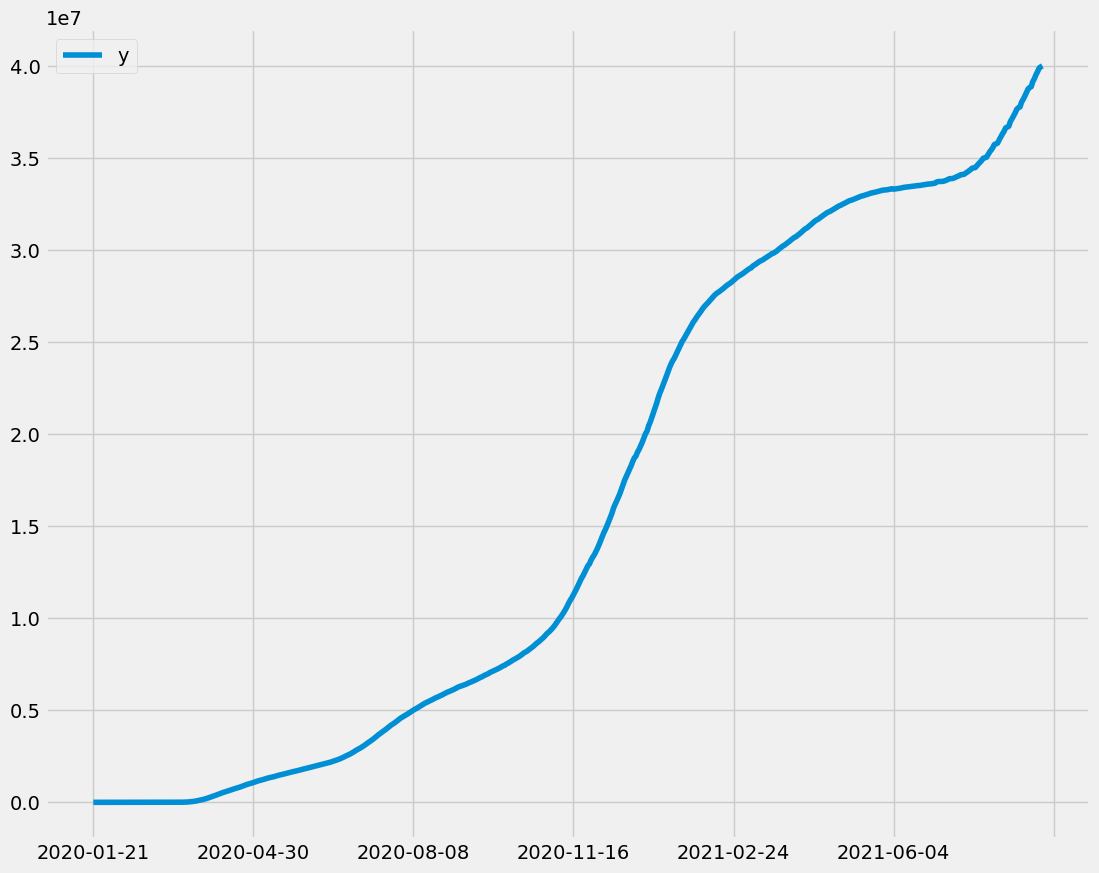

In [64]:
# Renaming cols and plotting the time series
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='');

12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing


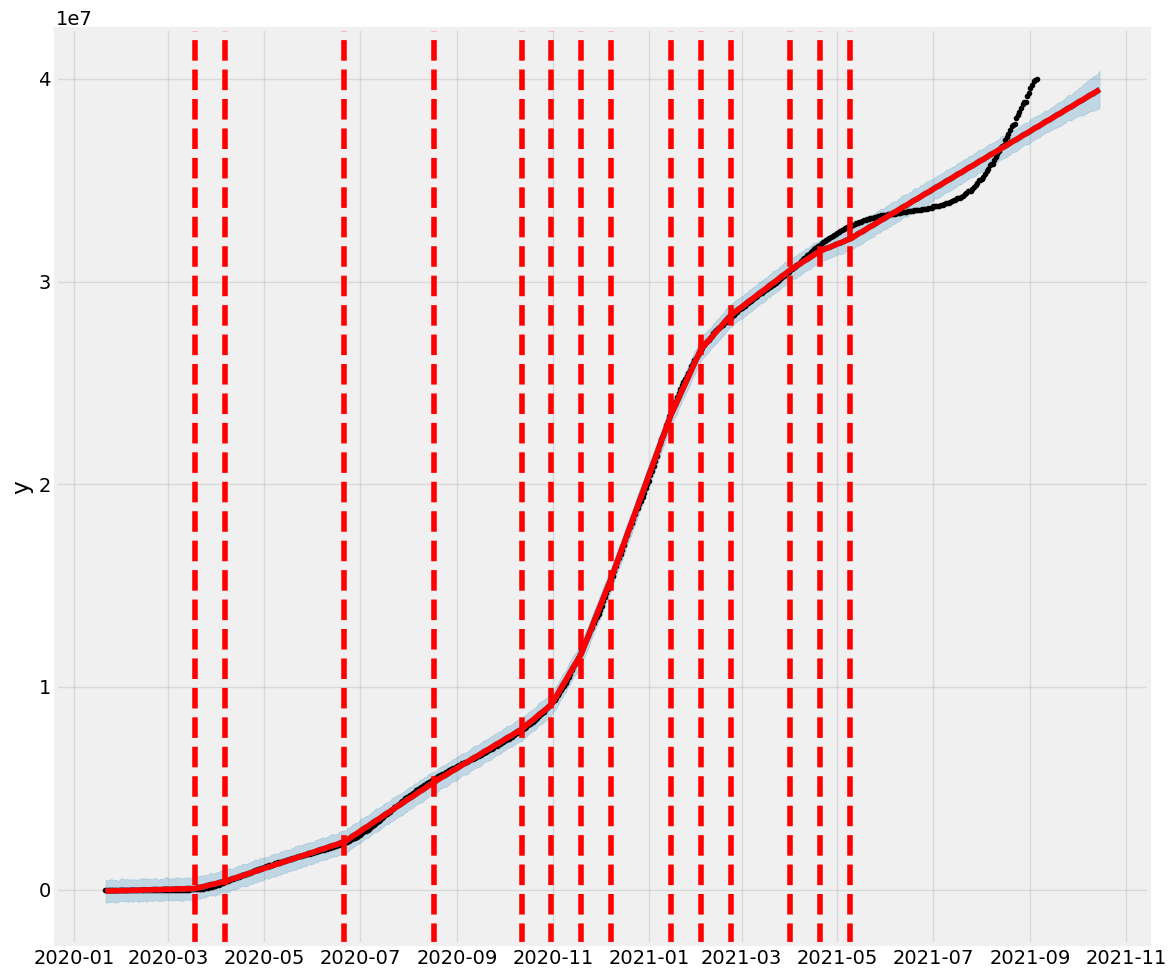

In [65]:
# Auto detect changepoints
m = Prophet()
m.fit(xdat)

future = m.make_future_dataframe(periods=40)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast);

We will need to adjust / shrink the changepoint parameter `changepoint_prior_scale`

12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


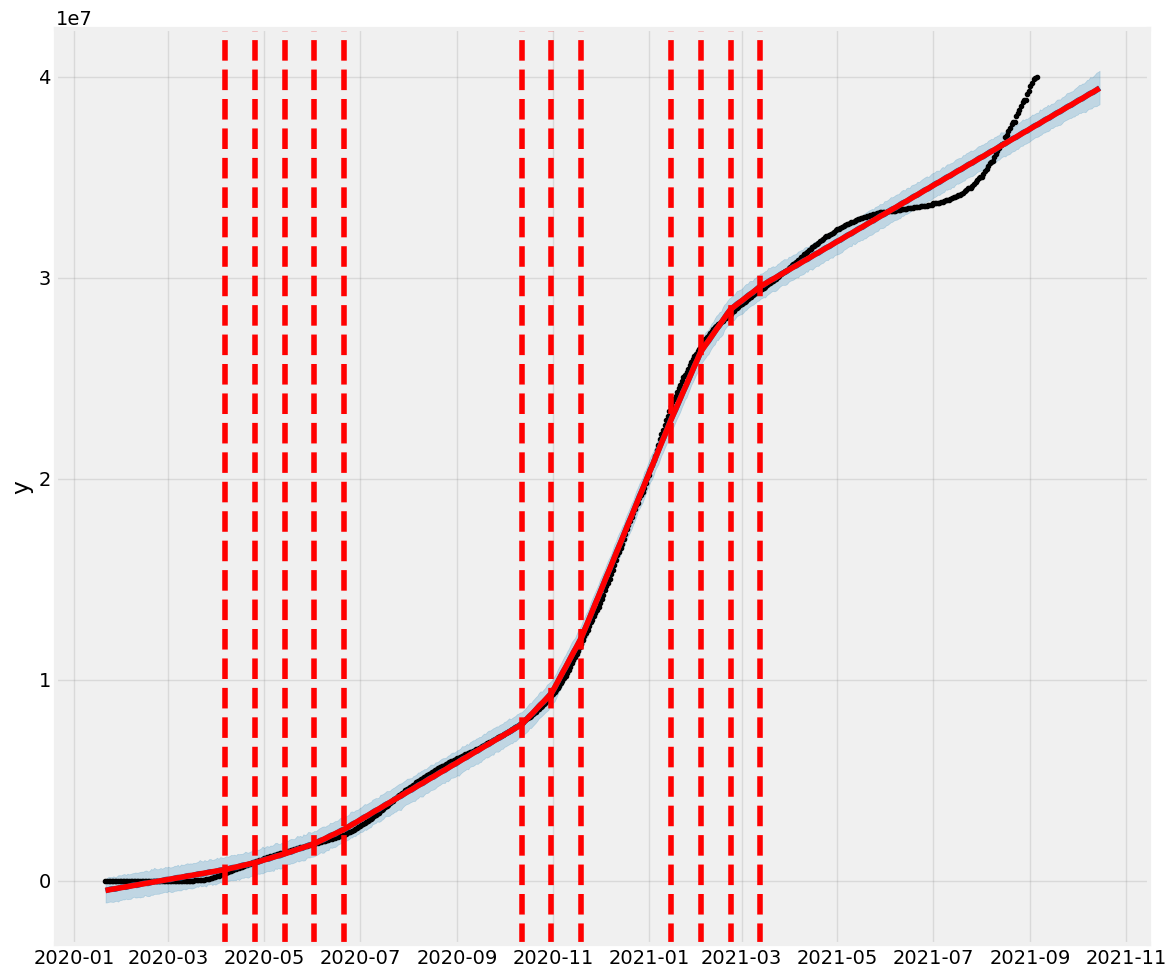

In [66]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)

future = m.make_future_dataframe(periods=40)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast);

### Non Linear Growth

Non-linear, Saturating Growth, can be represented in the form of the logistic growth model which allows us to model the saturation phase of the growth cycles.

$$
T(t) = \frac{C_1} {1 + \exp(-k(t - m))}
$$

Where:
 - $C$ is the carrying capacity.
 - $k$ is the growth rate or the steepness of the trend curve.

Prophet allows for automatic and manual tuning of the variability. Building on the previous example, lets move to China's data on Covid cases.

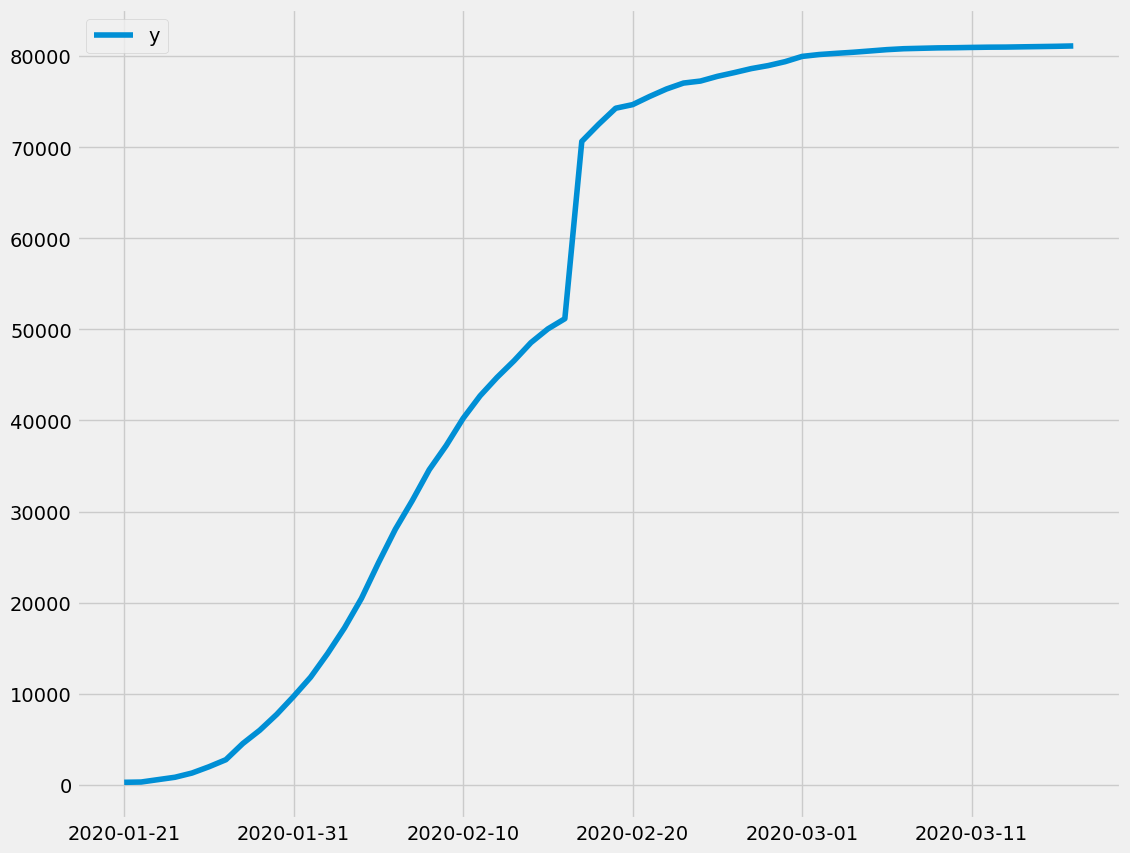

In [67]:
df = pd.read_csv(data + 'who-data/WHO_full_data2003.csv')
# Taking a subset of the data and renaming cols
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='');

12:32:03 - cmdstanpy - INFO - Chain [1] start processing
12:32:03 - cmdstanpy - INFO - Chain [1] done processing


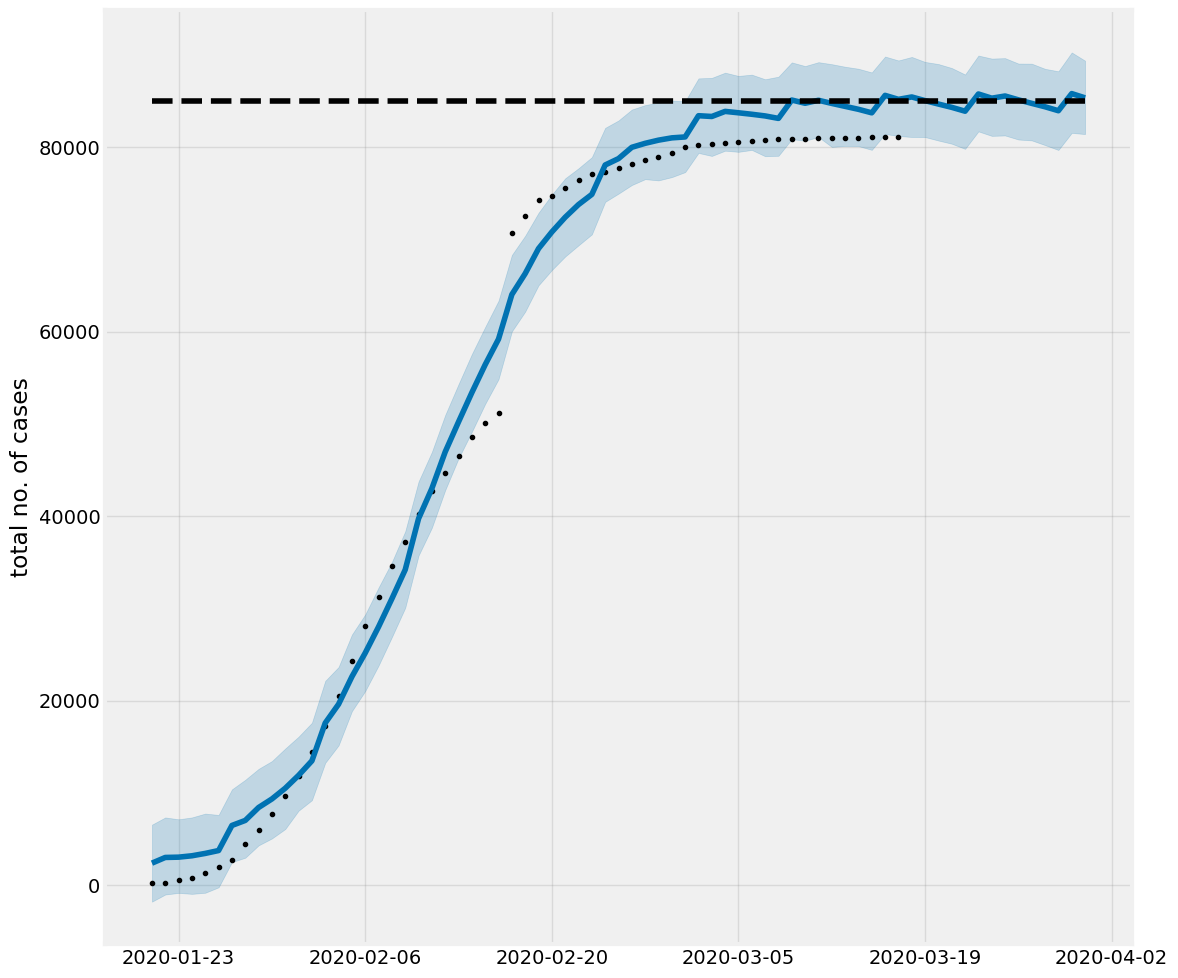

In [68]:
# Prophet can cap the forecast value as additional knowledge
df['cap'] = 85000

# Fit the model with growth parameter set to logistic.
m = Prophet(growth='logistic')
m.fit(df)
# Forecast
future = m.make_future_dataframe(periods=14)
future['cap'] = 85000
# Plot
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total no. of cases');

12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing


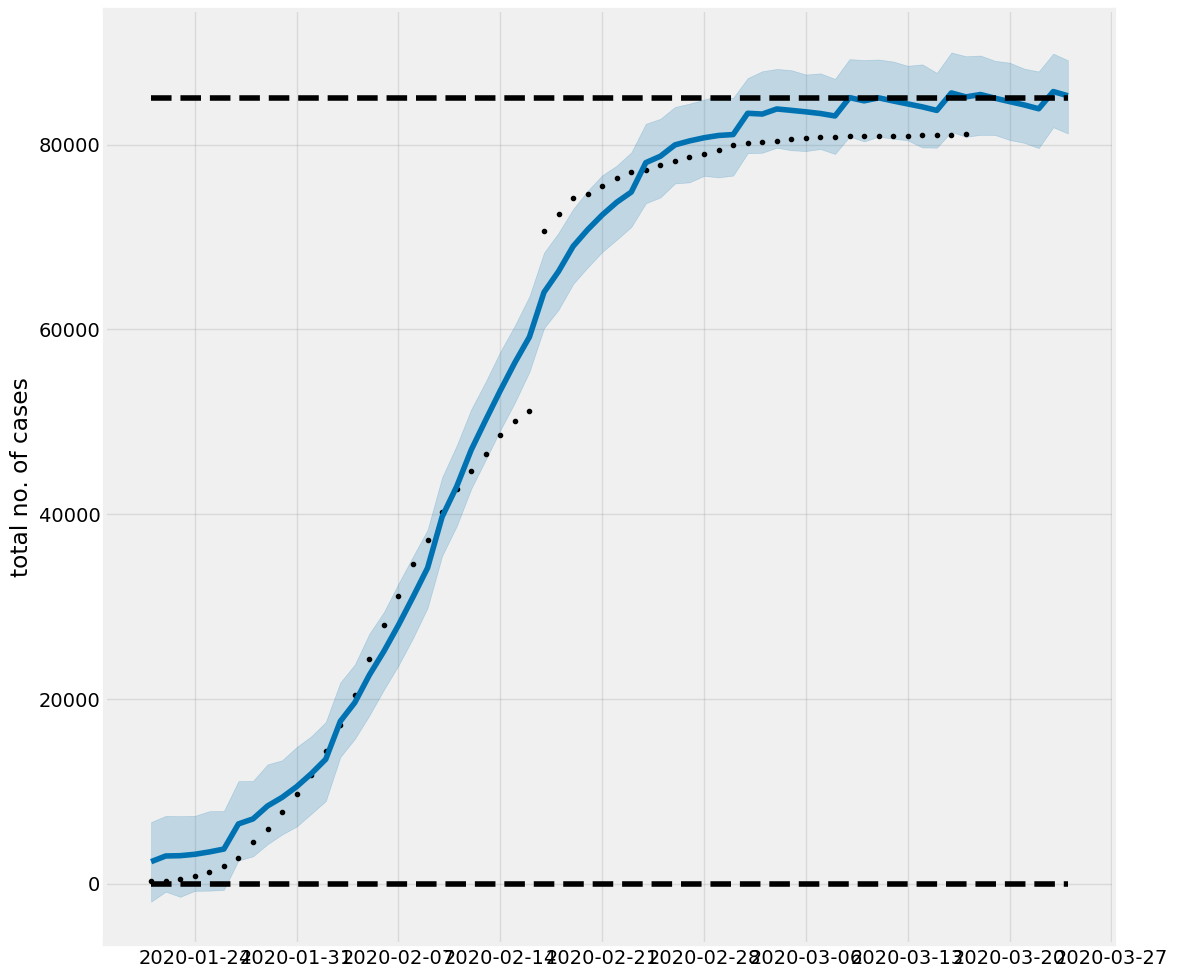

In [69]:
# The model can also incorporate about a floor as well as a cap
df['cap'] = 85000
df['floor'] = 0

# Fit the model
m = Prophet(growth='logistic')
m.fit(df)

# Predict
future = m.make_future_dataframe(periods=7)
future['cap'] = 85000
future['floor'] = 0
forecast = m.predict(future)
m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total no. of cases');
